In [2]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.8"
from jax.config import config
# This slows down the computation by ~ x8. But single precision leads to discretization effects.
config.update("jax_enable_x64", False)  
import jax.numpy as jnp
from jax import jit, vmap, random

import sys
sys.path.append("..")
from hyperion.propagate import (   
    make_initialize_direction_laser,
    make_photon_trajectory_fun,
    make_step_function,
    make_photon_circle_intersection,
    make_loop_for_n_steps,
    make_fixed_pos_time_initializer,
    make_monochromatic_initializer,
    collect_hits,
    sph_to_cart
)
from hyperion.medium import (
     cascadia_ref_index_func,
     mixed_hg_rayleigh_antares,
     sca_len_func_antares
)
from hyperion.constants import Constants
from hyperion.utils import calculate_min_number_steps, make_cascadia_abs_len_func
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import seaborn as sns
from scipy.interpolate import UnivariateSpline
import scipy.stats

# Propagate Photons from LED Lightsource

### Set detector parameters

In [3]:
# Define emitter position & emission time
emitter_x = jnp.array([0, 4.45, 12.54])
emitter_t = 0.0

# Define detector position & sensor radius (sensor is modelled as a sphere)
circle_pos = jnp.array([0, 0, 12.265])
circle_normal = jnp.array([0, 0, 1])
circle_radius = 0.0125



### Create Photon Initializers
Now setup the photon state initializers. We will use a function that injects photons at a fixed position and time and samples the direction and wavelength.
This function returns a dict which represents the initial photon state.

In [4]:
# LED emission profile (Lambert)

led_wavelength = 450

emission_dir_init = make_initialize_direction_laser(jnp.asarray([0, 0,  1.]))

# Monochromatic wavelength (laser probably has less than 5nm FWHM - does this matter?)
wavelength_init = make_monochromatic_initializer(led_wavelength)

photon_init = make_fixed_pos_time_initializer(emitter_x, emitter_t, emission_dir_init, wavelength_init)

### Create step function
Next, we are going to create a step function. This function will recieve a photon state, propagate the photon for one scattering step and return a new photon state.

In [5]:
# We want to calculate intersections with a sphere
intersection_f = make_photon_circle_intersection(circle_pos, circle_normal, circle_radius)

# Use an approximation to the ANTARES scattering function
scattering_function = mixed_hg_rayleigh_antares

# Use the ANTARES wavelength dependent scattering length
scattering_length_function = lambda wavelength: 100 # m
"""
Note: you can also set the `scattering_length_function` to `sca_len_func_antares`
"""
# Use the ANTARES wavelength dependent refractive index with cascadia basin properties
ref_index_func = cascadia_ref_index_func

# Create a step function, which will propagate the photon until the next scattering site.
# If the intersection function returns True, only propagate to intersection position.
step_fun = make_step_function(
    intersection_f=intersection_f,
    scattering_function=scattering_function,
    scattering_length_function=scattering_length_function,
    ref_index_func=ref_index_func,
)


/opt/conda/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:3650: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/opt/conda/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:3584: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")


### Step Size

Pick the step size such that 95% of all photons have a survival probability of < 1E-10

In [6]:
sca_len = scattering_length_function(led_wavelength)
abs_len = make_cascadia_abs_len_func(sca_len_func_antares)(led_wavelength)
print(f"Abs. length: {abs_len:.2f}m, Sca. length: {sca_len:.2f}m")

photon_prob_cutoff = 1E-10
steps = 12
prop_lengths = scipy.stats.gamma.rvs(steps, scale=sca_len, size=100000)
abs_weights = np.exp(-prop_lengths / abs_len)

perc_of_score = scipy.stats.percentileofscore(abs_weights, photon_prob_cutoff)

frac_surv = abs_weights.sum() / prop_lengths.shape[0]

print(f"Percent of photons with surv prob < {photon_prob_cutoff:.0E}: {perc_of_score:.1f}")
print(f"Combined fractional weight of photons : {frac_surv:.2E}")



Abs. length: 29.64m, Sca. length: 100.00m
Percent of photons with surv prob < 1E-10: 95.3
Combined fractional weight of photons : 1.01E-08


### Setup looping function

In [7]:
# Propagation is run until either photon intersects or max_time is reached
loop_func = make_loop_for_n_steps(steps)

# make a trajectory function
trajec_fun = make_photon_trajectory_fun(
    step_fun,
    photon_init,
    loop_func=loop_func,
)

# Create a compiled and vectorized trajectory function
trajec_fun_v = jit(vmap(trajec_fun, in_axes=[0]))

Text(0, 0.5, 'z[m]')

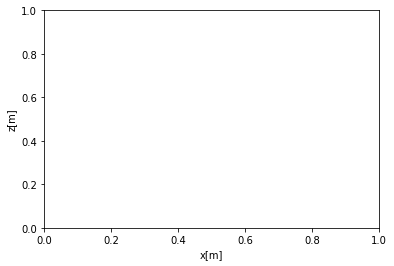

In [13]:
key, subkey = random.split(random.PRNGKey(1), 2)
n_photons = 1000000


# vmap and jit
step_fun_j = jit(vmap(step_fun, in_axes=0))
state = vmap(photon_init, in_axes=0)(random.split(subkey, n_photons))
positions = [np.asarray(state["pos"])]
isec = [np.asarray(state["isec"])]
times = [np.asarray(state["time"])]

key = random.split(key, n_photons)

for i in range(10):
    has_isec = state["isec"]

    new_state, key = step_fun_j(state, key)
    state = {
        "pos": jnp.where(has_isec[:, np.newaxis], state["pos"], new_state["pos"]),
        "dir": jnp.where(has_isec[:, np.newaxis], state["dir"], new_state["dir"]),
        "isec": jnp.where(has_isec, state["isec"], new_state["isec"]),
        "time": jnp.where(has_isec, state["time"], new_state["time"]),
        "stepcnt": jnp.where(has_isec, state["stepcnt"], new_state["stepcnt"]),
        "wavelength": jnp.where(has_isec, state["wavelength"], new_state["wavelength"]),
    }

    positions.append(np.asarray(state["pos"]))
    times.append(np.asarray(state["time"]))
    isec.append(np.asarray(state["isec"]))



    
positions = np.asarray(positions)
isec = np.asarray(isec)
times = np.asarray(times)
"""
for i_photon in range(n_photons):
    plt.plot(positions[:, i_photon, 0], positions[:, i_photon, 2], color="k", alpha=0.1);
"""
for i_photon in range(n_photons):
    if np.any(isec[:, i_photon]):
        plt.plot(positions[:, i_photon, 0], positions[:, i_photon, 2], color="r", alpha=1);
#plt.xlim(-20, 20)
#plt.ylim(-20, 20)
plt.xlabel("x[m]")
plt.ylabel("z[m]")


In [12]:
print(times[-1, np.any(isec, axis=0)])

[]


## Propagate multiple batches of photons
We can use another convenience function to propagate multiple batches of photons, and record only those that have hit our detector.

In [25]:
def collect_hits(traj_func, nphotons, nsims, seed=0, sim_limit=1e7):
    """Run photon prop multiple times and collect hits."""
    key = random.PRNGKey(seed)
    isec_times = []
    ar_dirs = []
    nphotons = int(nphotons)
    isec_pos = []

    total_detected_photons = 0
    sims_cnt = 0

    for i in range(nsims):
        key, subkey = random.split(key)
        initial_state, final_state = traj_func(random.split(key, num=nphotons))
        isecs = final_state["isec"]
        isec_times.append(np.asarray(final_state["time"][isecs]))      
        ar_dirs.append(np.asarray((final_state["dir"][isecs])))
        isec_pos.append(np.asarray(final_state["pos"][isecs]))

        sims_cnt = i
        total_detected_photons += jnp.sum(isecs)
        if sim_limit is not None and total_detected_photons > sim_limit:
            break

    isec_times = np.concatenate(isec_times)
    ar_dirs = np.vstack(ar_dirs)
    isec_pos = np.vstack(isec_pos)


    return isec_times, ar_dirs, isec_pos, sims_cnt


In [50]:
data = collect_hits(trajec_fun_v, 5E6, 1500)

<AxesSubplot:ylabel='Count'>

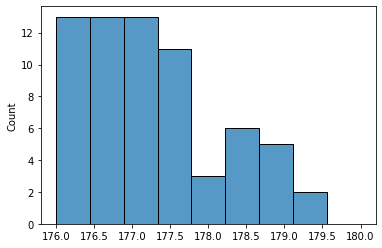

In [51]:
sns.histplot(np.degrees(jnp.arccos(data[1][:, 2])), bins=np.linspace(176, 180, 10))


Text(0.5, 0, 'Time (ns)')

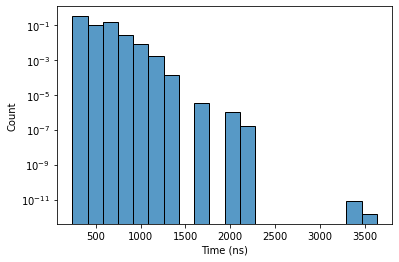

In [52]:
fov_cut = np.degrees(jnp.arccos(data[1][:, 2])) > 176
c_medium_f = lambda wl: Constants.BaseConstants.c_vac / cascadia_ref_index_func(wl)
arriv_times = data[0]
prop_dist = data[0] * c_medium_f(led_wavelength)/1E9 
abs_weight = np.exp(-prop_dist / abs_len)


sns.histplot(x=arriv_times[fov_cut], bins=20, weights=abs_weight[fov_cut])
plt.semilogy()
plt.xlabel("Time (ns)")


In [53]:
laser_theta = np.radians(5)

laser_dir = sph_to_cart(laser_theta, 0)
print(laser_dir)
emission_dir_init_2 = make_initialize_direction_laser(laser_dir)

photon_init_2 = make_fixed_pos_time_initializer(emitter_x, emitter_t, emission_dir_init_2, wavelength_init)

second_trajec_fun = make_photon_trajectory_fun(
    step_fun,
    photon_init_2,
    loop_func=loop_func,
)

second_trajec_fun_v = jit(vmap(second_trajec_fun, in_axes=[0]))
data2 = collect_hits(second_trajec_fun_v, 5E6, 1500)

[0.08715574 0.         0.9961947 ]


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


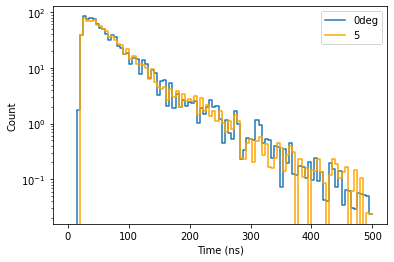

In [54]:
def make_plot_data(data):

    arriv_times = data[0]
    prop_dist = data[0] * c_medium_f(led_wavelength)/1E9 
    abs_weight = np.exp(-prop_dist / abs_len)

    return arriv_times, abs_weight, np.degrees(jnp.arccos(data[1][:, 2]))

pl_data_1 = make_plot_data(data)
pl_data_2 = make_plot_data(data2)

sns.histplot(x=pl_data_1[0], bins=np.linspace(0, 500, 100), weights=pl_data_1[1], label="0deg", fill=False, element="step")
sns.histplot(x=pl_data_2[0], bins=np.linspace(0, 500, 100), weights=pl_data_2[1], color="orange", label=f"{np.degrees(laser_theta):.0f}", fill=False, element="step")



plt.semilogy()
plt.xlabel("Time (ns)")
plt.legend()


Text(0.5, 1.0, '5 deg inclination')

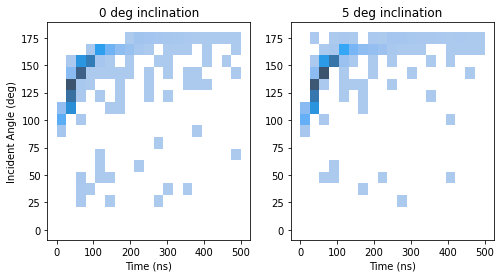

In [55]:
fig, axs = plt.subplots(1 ,2, figsize=(8, 4))


sns.histplot(x=pl_data_1[0], y=pl_data_1[2], weights=pl_data_1[1], bins=(np.linspace(0, 500, 20), np.linspace(0, 180, 18)), ax=axs[0])
axs[0].set_xlabel("Time (ns)")
axs[0].set_ylabel("Incident Angle (deg)")
axs[0].set_title("0 deg inclination")

sns.histplot(x=pl_data_2[0], y=pl_data_2[2], weights=pl_data_2[1], bins=(np.linspace(0, 500, 20), np.linspace(0, 180, 18)), ax=axs[1])
axs[1].set_xlabel("Time (ns)")
axs[1].set_title(f"{np.degrees(laser_theta):.0f} deg inclination")
#axs[0].set_ylabel("Incident Angle (deg)")

In [47]:
np.degrees(np.arccos(0.97))

14.069867747572133

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


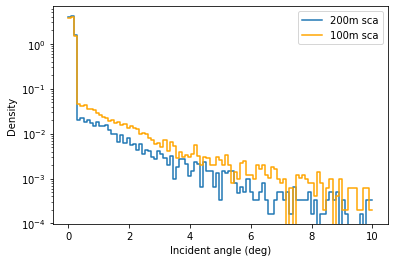

In [ ]:
def make_plot_data(data):

    arriv_dirs = data[1]
    theta = np.arccos(arriv_dirs[:, 2])
    prop_dist = data[0] * c_medium_f(led_wavelength)/1E9 
    abs_weight = np.exp(-prop_dist / abs_len)

    return theta, abs_weight


pl_data_1 = make_plot_data(data)
pl_data_2 = make_plot_data(data2)

sns.histplot(x=np.degrees(pl_data_1[0]), bins=np.linspace(0, 10, 100), weights=pl_data_1[1], stat="density", label="200m sca", fill=False, element="step")
sns.histplot(x=np.degrees(pl_data_2[0]), bins=np.linspace(0, 10, 100), weights=pl_data_2[1], color="orange", stat="density", label="100m sca", fill=False, element="step")



plt.semilogy()
plt.xlabel("Incident angle (deg)")
plt.legend()
